# Introduction

   This is an attempt to predict Stock prices based on Stock prices of previous days. [The stock market](https://www.investopedia.com/terms/s/stockmarket.asp) refers to the collection of markets and exchanges where regular activities of buying, selling, and issuance of shares of publicly-held companies take place. 
   
  This is a time series analysis and we will see simple eight ways to predict the Stock prices. The various models to be used are:
   1. Average
   2. Weighted Average
   3. Moving Average
   4. Moving Weighted Average
   5. Linear Regression
   6. Weighted Linear Regression
   7. Lasso Regression
   8. Moving Window Neural Network 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as mse

In [60]:
#Creating a list for company name
company_list = ['INFY' , 'TCS']
company_LC = ['infy' , 'tcs']

# The Data
   
   
   The data we use for prediction would be for closing price of [Infosys](https://www.infosys.com/) in NSE for the business days in 2015. So we will import only the Date column and Closing price column. 

In [39]:
# Create a dictionary of DataFrames
df = {} 

for i,comp in enumerate(company):
    
    #storing the data from csv in the dictionary
    df[comp] = pd.read_csv(f"./archive/{company_LC[i]}_stock.csv",
                     usecols=['Date','Open', 'High', 'Low','Close', 'Volume'], parse_dates=['Date'],index_col='Date')

We have data on working days only and so there are 248 data with start date as 01-01-2015 and end date as 31-12-2015.

In [45]:
# Display the first few values of one of the dataframe
# df['INFY'].head()
df['TCS'].head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-01,2567.0,2567.00,2541.00,2545.55,183415
2015-01-02,2551.0,2590.95,2550.60,2579.45,462870
2015-01-05,2581.0,2599.90,2524.65,2540.25,877121
2015-01-06,2529.1,2529.10,2440.00,2446.60,1211892
2015-01-07,2470.0,2479.15,2407.45,2417.70,1318166


In [54]:
company
df[company[1]].loc['2015-01-07',:]

Open         2470.00
High         2479.15
Low          2407.45
Close        2417.70
Volume    1318166.00
Name: 2015-01-07 00:00:00, dtype: float64

In [58]:
df[company[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2015-01-01 to 2015-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    248 non-null    float64
 1   High    248 non-null    float64
 2   Low     248 non-null    float64
 3   Close   248 non-null    float64
 4   Volume  248 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 19.7 KB


In [59]:
company_name = company[0];
print("Min:",df[company_name].index.min())
print("Max:",df[company_name].index.max())

Min: 2015-01-01 00:00:00
Max: 2015-12-31 00:00:00


In [65]:
company_list

['INFY', 'TCS']

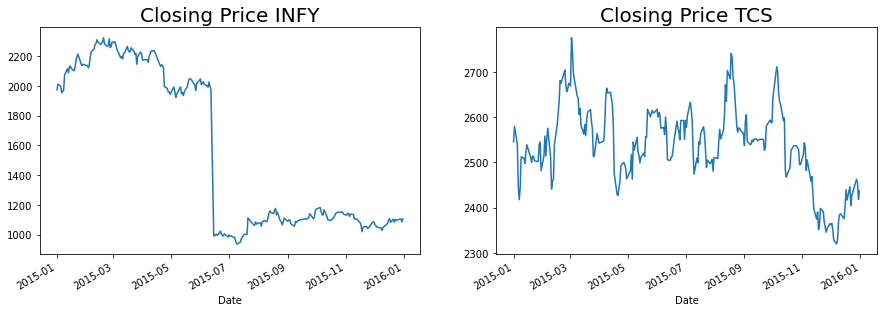

In [75]:
plt.figure(figsize=(15,3))
plt.subplots_adjust(top=1.25 , bottom = 1.2)

for i,company in enumerate(company_list,1):
    plt.subplot(1,2,i)
    df[company].Close.plot()
    plt.title(f"Closing Price {company}",fontsize=20)
plt.show()

In [80]:
column_name = df[company_list[0]].columns[3:5]

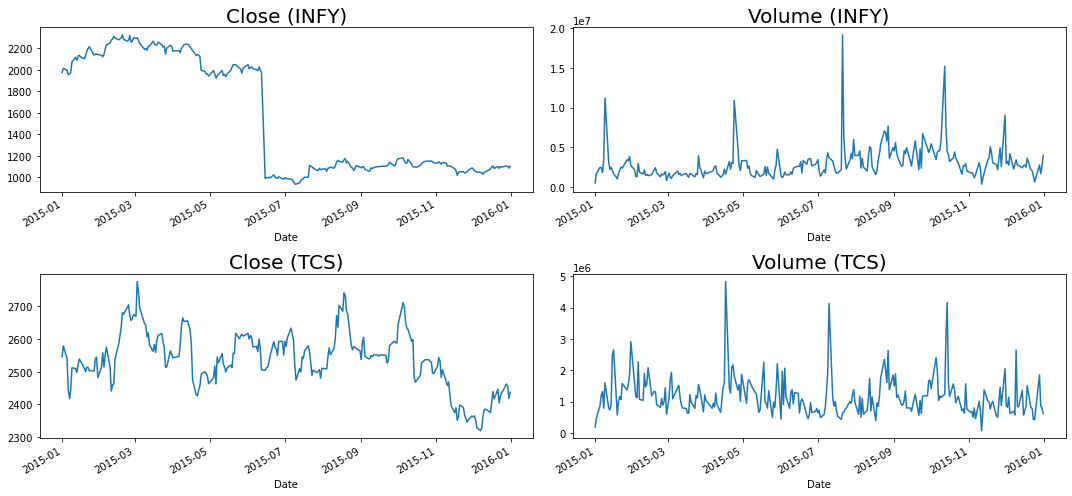

In [91]:
plt.figure(figsize=(15,7))
plt.subplots_adjust(top=3 , bottom = 1.5)

column_name = df[company_list[0]].columns[3:5]
k = 1;
for i,company in enumerate(company_list, 1):
    
    for j,column in enumerate(column_name,1):
        plt.subplot(2,2,k)
        df[company][column].plot()
        k = k+1;
        plt.title(f"{column} ({company})",fontsize=20)

plt.tight_layout()
plt.show()

In [95]:
df[company_list[0]].Close['2015-06-12']

1975.05

# Adjustment for split-up

There is a huge drop on 15/06/2015, this was the [fifth split](https://www.splithistory.com/infy/) in Infosys Share price. If we take this whole data, the prediction might not be  as expected as there is a split in between!

We have to either drop the data or adjust the values before split. Since the split is 2 for 1, we can normalize the data prior to split by dividing them by 2. (Old shares are half that of today's share).

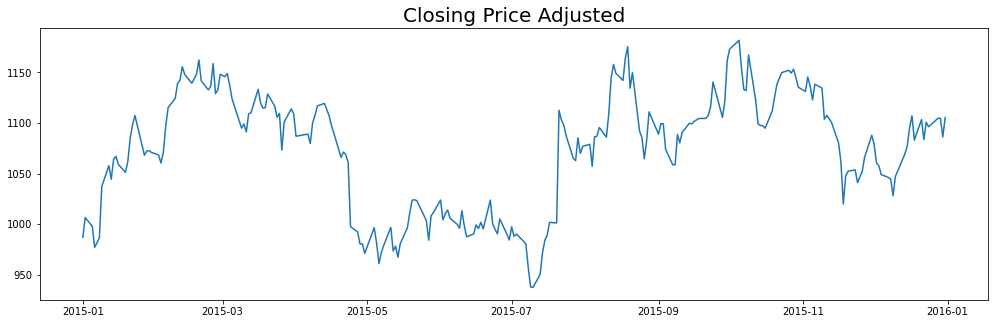

In [97]:
# Ajusting the split for INFY stock that happened on 15/06/2015
plt.figure(figsize=(17,5))
stock_price = pd.concat([df[company_list[0]].Close[:'2015-06-12']/2,df[company_list[0]].Close['2015-06-15':]]) # adjustment
plt.plot(stock_price)
plt.title("Closing Price Adjusted",fontsize=20)
plt.show()

And now we have an adjusted time series of Infosys stock prices.

Lets now Predict the Stock price based on various methods. 
 
* We will predict the values on last 68 days in the series.
* We will use Mean squared error as a metrics to calculate the error in our prediction.
* We will compare the results of various methods at the end.

In [98]:
#helper function to plot the stock prediction
prev_values = stock_price.iloc[:180] #train
y_test = stock_price.iloc[180:] #test

def plot_pred(pred,title):
    plt.figure(figsize=(17,5))
    plt.plot(prev_values,label='Train')
    plt.plot(y_test,label='Actual')
    plt.plot(pred,label='Predicted')
    plt.ylabel("Stock prices")
    plt.title(title,fontsize=20)
    plt.legend()
    plt.show()

# 1. Average 

This is the simplest model. We will get as average of the previous values and predict it as the forecast. 

In [99]:
#Average of previous values
y_av = pd.Series(np.repeat(prev_values.mean(),68),index=y_test.index)
mse(y_av,y_test)

3173.635647600105

In [100]:
np.sqrt(mse(y_av,y_test))

56.33503037720052

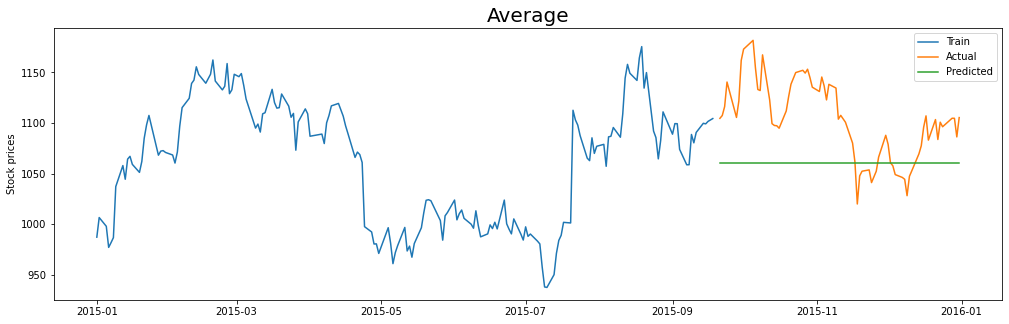

In [101]:
plot_pred(y_av,"Average")

# 2. Weighted Mean

We shall give more weightage to the data which are close to the last day in training data, while calculating the mean. The last day in the training set will get a weightage of 1(=180/180) and the first day will get a weightage of 1/180.

In [15]:
weight = np.array(range(0,180))/180
weighted_train_data =np.multiply(prev_values,weight)

# weighted average is the sum of this weighted train data by the sum of the weight

weighted_average = sum(weighted_train_data)/sum(weight)
y_wa = pd.Series(np.repeat(weighted_average,68),index=y_test.index)

print("MSE: " ,mse(y_wa,y_test))
print("RMSE: " ,np.sqrt(mse(y_wa,y_test)))

MSE:  3496.475652551586
RMSE:  59.1310041564625


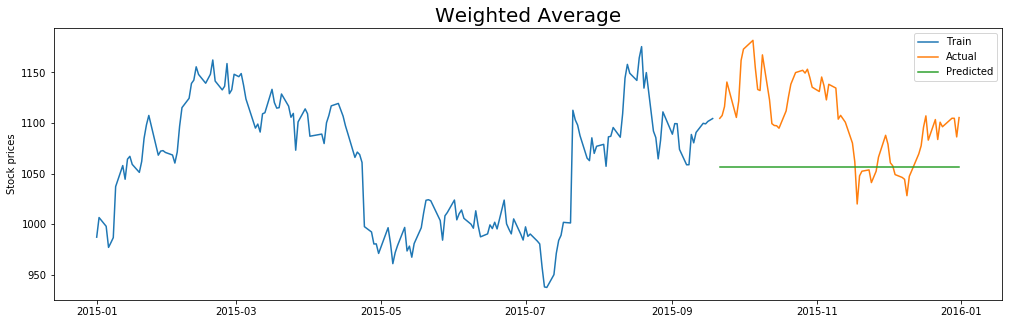

In [16]:
plot_pred(y_wa,"Weighted Average")

    For the other methods we will predict the value of stock price on a day based on the values of stock prices of 80 days prior to it. So in our series we will not consider the first eight days (since there previous eighty days is not in the series).
    We have to test the last 68 values. This would be based on the last 80 days stock prices of each day in the test data.
    Since we have neglected first 80 and last 68 is our test set, the train dataset will be between 80 and 180 (100 days).

In [17]:
y_train = stock_price[80:180]
y_test = stock_price[180:]
print("y train:",y_train.shape,"\ny test:",y_test.shape)

y train: (100,) 
y test: (68,)


 There are 100 days in training and 68 days in testing set. We will construct the features, that is the last 80 days stock for each date in the y_train and y_test. This would be our target variable.

In [18]:
X_train = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100)],
                       columns=range(80,0,-1),index=y_train.index)
X_test = pd.DataFrame([list(stock_price[i:i+80]) for i in range(100,168)],
                       columns=range(80,0,-1),index=y_test.index)

X_train

,80,79,78,77,76,75,74,73,72,71,...,10,9,8,7,6,5,4,3,2,1
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,987.200,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,...,1097.325,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575
2015-05-04,1006.600,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,...,1089.625,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125
2015-05-05,997.950,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,...,1066.075,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550
2015-05-06,977.100,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,...,1071.300,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375
2015-05-07,981.775,986.725,1037.225,1057.975,1044.450,1064.325,1067.125,1059.150,1051.250,1062.100,...,1068.850,1061.000,997.600,992.325,980.450,980.575,971.125,996.550,981.375,961.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-11,1023.225,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,...,1111.050,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450
2015-09-14,1008.400,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,...,1094.400,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750
2015-09-15,1003.650,984.250,1008.300,1011.575,1023.900,1004.325,1010.450,1014.025,1005.825,1000.025,...,1089.000,1099.450,1099.350,1073.950,1058.750,1058.800,1088.700,1080.450,1090.750,1099.750


      X_train is now a collection of 100 dates as index and a collection of stock prices of previous 80 days as features.
    
      Similarlily, X_test is now a collection of 68 dates as index and a collection of stock prices of previous 80 days as features.
      
      NOTE: Here 76 working days from '2015-05-04', the stock had a price of 986.725 and 77 working days from '2015-05-05', the stock has the same value. You can see the similarity of values along the diagonal. This is because consecutitive data will be similar to the previous except it drops the last value, shifts and has a new value.
      
      We will use these values for stock price prediction in the other four methods.

# 3. Moving Average
   We have to predict the 68 values in data set and for each values we will get the average of previous 80 days.  
   This will be a simple mean of each column in the y_test.

In [19]:
y_ma = X_test.mean(axis=1)
mse(y_ma,y_test), np.sqrt(mse(y_ma,y_test))

(2901.424183296478, 53.86486965821488)

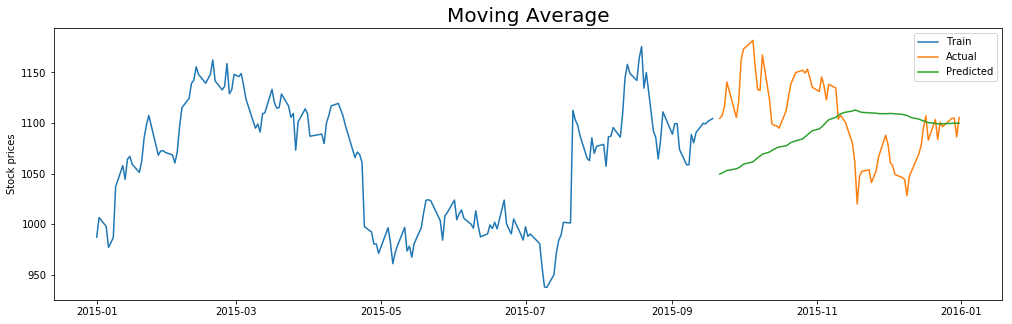

In [20]:
plot_pred(y_ma,"Moving Average")

# 4. Weighted Moving Average

We will obtain the stock price on the test date by calculating the weighted mean of past 80 days. The last of the 80 day will have a weightage of 1(=80/80) and the first will have a weightage of 1/80. 

In [21]:
weight = np.array(range(1,81))/80
#weighted moving average
y_wma = X_test@weight/sum(weight)
mse(y_wma,y_test),np.sqrt(mse(y_wma,y_test))

(1769.4332039308204, 42.064631270591455)

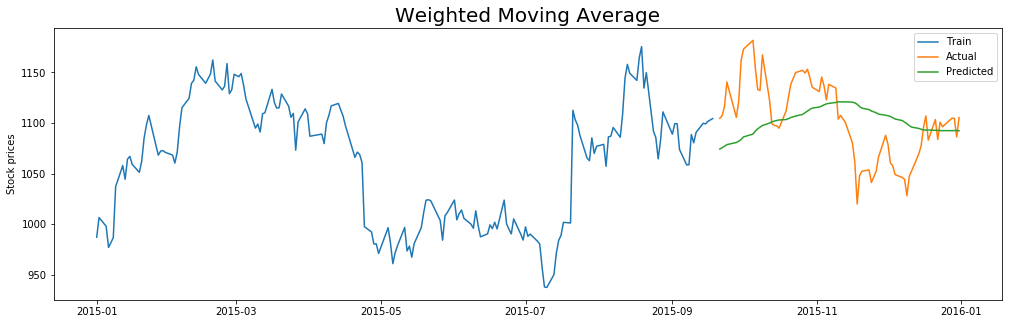

In [22]:
plot_pred(y_wma,"Weighted Moving Average")

# 4. Linear regression
   In this method, we will perform a linear regression on our dataset. The values will be predicted as a linear combination of the previous 80 days values. 

In [23]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

lr.fit(X_train,y_train) # Training the models
y_lr = lr.predict(X_test) # inference
y_lr = pd.Series(y_lr,index=y_test.index)

mse(y_test,y_lr), np.sqrt(mse(y_test,y_lr))

(1754.1645412925632, 41.88274753753105)

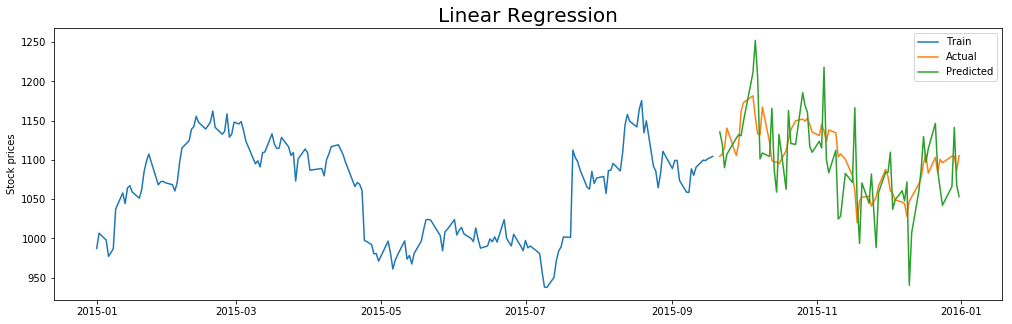

In [24]:
plot_pred(y_lr,"Linear Regression")

# 6. Weighted Linear Regression
We will provide weightage to our input data rather than the features. 

In [25]:
weight = np.array(range(1,101))/100
wlr = LinearRegression()

wlr.fit(X_train,y_train,weight)
y_wlr = wlr.predict(X_test)
y_wlr = pd.Series(y_wlr,index=y_test.index)

mse(y_test,y_wlr), np.sqrt(mse(y_test,y_wlr))

(2054.3614078787523, 45.32506379343279)

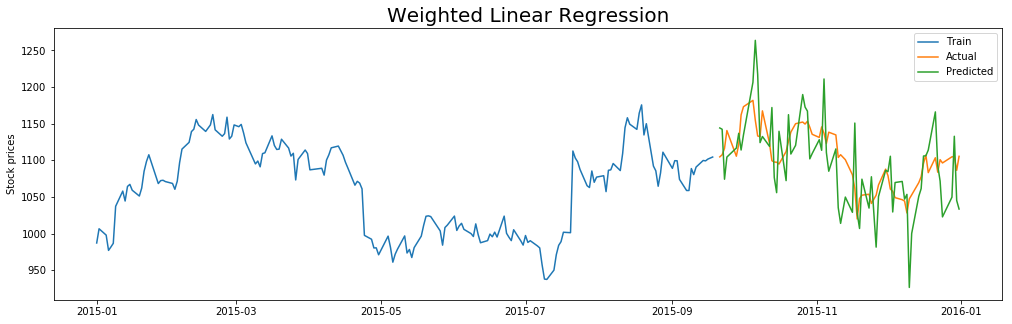

In [26]:
plot_pred(y_wlr,"Weighted Linear Regression")

# 7. Lasso Regression

Linear Regression with L1 regulations.

In [27]:
from sklearn.linear_model import Lasso
lasso = Lasso()

las = lasso.fit(X_train,y_train)
y_las = las.predict(X_test)
y_las = pd.Series(y_las,index = y_test.index)

mse(y_las,y_test), np.sqrt(mse(y_test,y_wlr))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 502.00215286973526, tolerance: 33.91328653187501
  positive)


(1467.333864613377, 45.32506379343279)

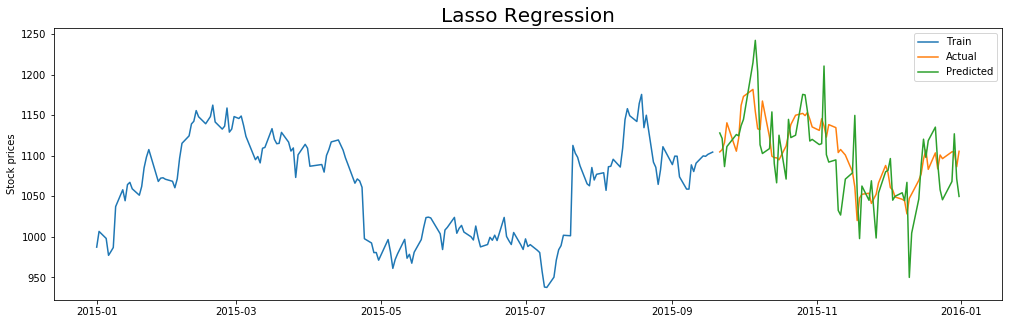

In [28]:
plot_pred(y_las,"Lasso Regression")

# 8. Moving window Neural Network

We construct a simple Feed Forward network taking 80 features as our input.

In [29]:
from keras.models import Sequential
from keras.layers import Dense

#moving average Neural Network
ma_nn = Sequential([Dense(64,input_shape=(80,),activation='relu'), 
                    Dense(32,activation='linear'),Dense(1)])

ma_nn.compile(loss='mse',optimizer='rmsprop',metrics=['mae','mse'])

history = ma_nn.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.25)

Using TensorFlow backend.


Train on 75 samples, validate on 25 samples
Epoch 1/250
75/75 [==============================] - 0s 3ms/step - loss: 7426359.7075 - mae: 2488.9771 - mse: 7426360.5000 - val_loss: 352022.4062 - val_mae: 590.2841 - val_mse: 352022.4062
Epoch 2/250
75/75 [==============================] - 0s 98us/step - loss: 73745.1156 - mae: 235.6134 - mse: 73745.1172 - val_loss: 48408.3867 - val_mae: 210.6606 - val_mse: 48408.3867
Epoch 3/250
75/75 [==============================] - 0s 84us/step - loss: 15247.4467 - mae: 107.2539 - mse: 15247.4463 - val_loss: 83155.4531 - val_mae: 281.5233 - val_mse: 83155.4531
Epoch 4/250
75/75 [==============================] - 0s 102us/step - loss: 17848.7841 - mae: 99.0921 - mse: 17848.7832 - val_loss: 62950.1641 - val_mae: 243.0046 - val_mse: 62950.1641
Epoch 5/250
75/75 [==============================] - 0s 89us/step - loss: 15101.4673 - mae: 97.5411 - mse: 15101.4668 - val_loss: 45681.5586 - val_mae: 204.4129 - val_mse: 45681.5586
Epoch 6/250
75/75 [============

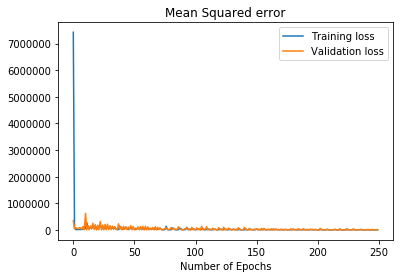

In [30]:
plt.plot(history.history['mse'],label='Training loss')
plt.plot(history.history['val_mse'], label='Validation loss')
plt.title("Mean Squared error")
plt.xlabel("Number of Epochs")
plt.legend()
plt.show()

In [31]:
loss_nn,mae_nn,mse_nn = ma_nn.evaluate(X_test,y_test)
print("\nloss:",loss_nn,"\nmae:",mae_nn,"\nmse:",mse_nn)

68/68 [==============================] - 0s 78us/step

loss: 8670.560776654413 
mae: 84.66361999511719 
mse: 8670.560546875


In [32]:
y_nn = ma_nn.predict(X_test)
y_nn = pd.Series(y_nn[:,0],index=y_test.index)
mse(y_nn,y_test),np.sqrt(mse(y_nn,y_test))

(8670.561191992329, 93.11584823214751)

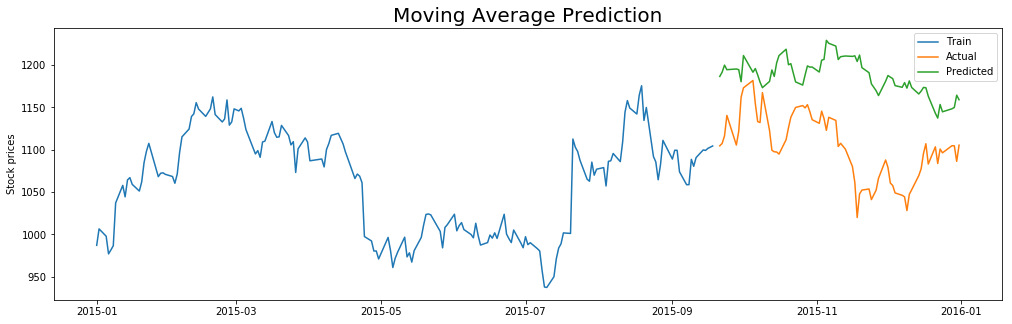

In [33]:
plot_pred(y_nn,"Moving Average Prediction")

The above methods are simple models. We will see more about classical time series analysis in the another notebook (Will update soon).

Feedbacks are most welcomed!

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [35]:
df=pd.read_csv(r"../input/national-stock-exchange-time-series/infy_stock.csv")
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2015-01-01,INFY,EQ,1972.55,1968.95,1982.00,1956.9,1971.00,1974.40,1971.34,500691,9.870306e+13,14908,258080,0.5154
1,2015-01-02,INFY,EQ,1974.40,1972.00,2019.05,1972.0,2017.95,2013.20,2003.25,1694580,3.394669e+14,54166,1249104,0.7371
2,2015-01-05,INFY,EQ,2013.20,2009.90,2030.00,1977.5,1996.00,1995.90,2004.59,2484256,4.979911e+14,82694,1830962,0.7370
3,2015-01-06,INFY,EQ,1995.90,1980.00,1985.00,1934.1,1965.10,1954.20,1954.82,2416829,4.724458e+14,108209,1772070,0.7332
4,2015-01-07,INFY,EQ,1954.20,1965.00,1974.75,1950.0,1966.05,1963.55,1962.59,1812479,3.557162e+14,62463,1317720,0.7270


Epoch 1/1
 - 6s - loss: 0.0342


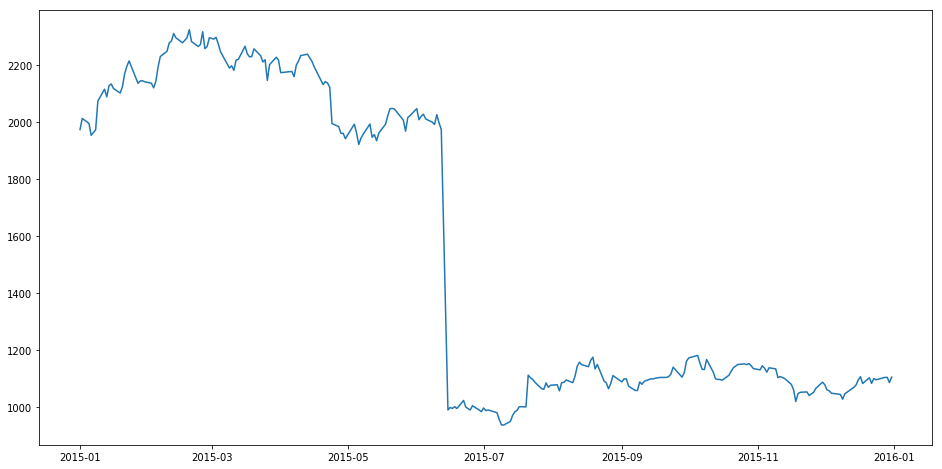

In [36]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]
    

new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_data=final_dataset[0:187,:]
valid_data=final_dataset[187:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))




lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

In [37]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

In [38]:
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

lstm_model.save("saved_lstm_model.h5")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


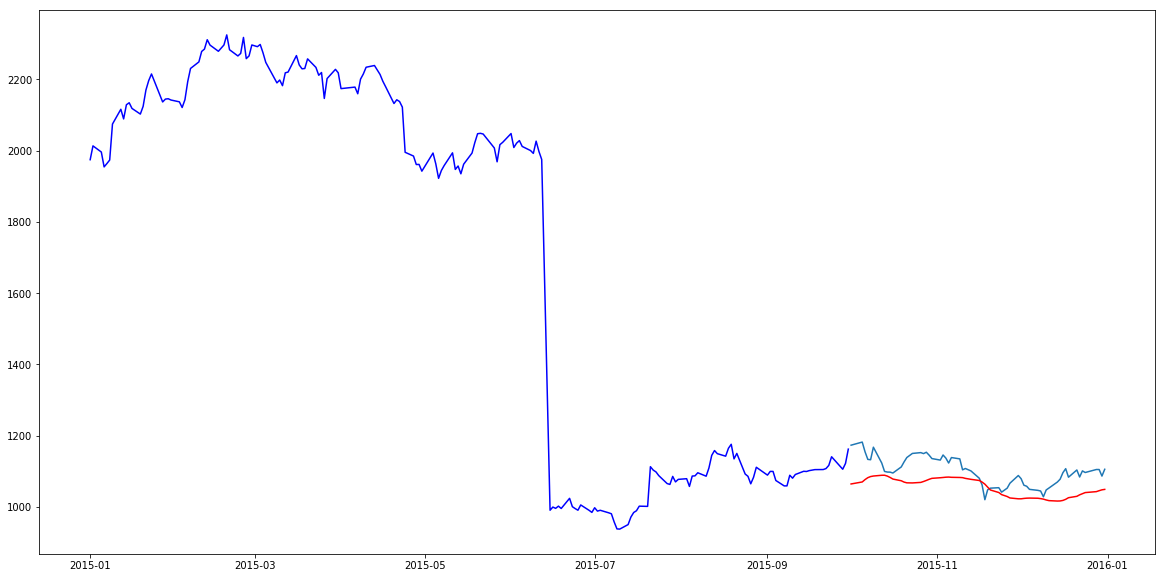

In [39]:
train_data=new_dataset[:187]
valid_data=new_dataset[187:]
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"],color='blue')
plt.plot(valid_data["Close"])
plt.plot(valid_data["Predictions"], color='red')